## Evaluation

PSNR, SSIM, visualize check

In [14]:
import os 

import numpy as np
import matplotlib.pyplot as plt

import h5py


from skimage.metrics import peak_signal_noise_ratio as cal_psnr
from skimage.metrics import structural_similarity as cal_ssim

import sys
sys.path.append('../')

from module.datasets import load_4d_dicom
from module.utils import display_4d_image, compute_psnr_ssim_from_4d_ndarray, plot_2d_data, plot_image_with_zoom

## Load noisy data and denoised data

In [2]:
with h5py.File('../dataset/preprocessed/PT_20p 150_120 OSEM_gauss_0.009.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = f['restore_info'][...]


# denormalized 
print(restore_info)

mean_val = 201.12048776036573
std_val = 1412.4139804758772
max_val = 23.05689405684542
min_val = -23.34168377224119


noisy_data = noisy_data * (max_val - min_val) + min_val
noisy_data = noisy_data * std_val + mean_val

noisy_data = np.clip(noisy_data, np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)

# 
print(f"noisy_data: {noisy_data.dtype} shape: {noisy_data.shape}; range({np.min(noisy_data)}, {np.max(noisy_data)}); mean:{np.mean(noisy_data)}; std:{np.std(noisy_data)}")

b'{"mean": 201.12048776036573, "std": 1412.4139804758772, "min": -23.34168377224119, "max": 23.05689405684542}'
noisy_data: int16 shape: (24, 71, 192, 192); range(-32768, 32767); mean:200.9238672072401; std:1530.3175702236847


In [3]:
denoised_data_folder = "../dataset/denoised/BM4D/PT_20p 150_120 OSEM_gauss_0.009/"

denoised_data = load_4d_dicom(denoised_data_folder)

print(f"denoised_data: {denoised_data.dtype} shape:{denoised_data.shape} range({np.min(denoised_data)}, {np.max(denoised_data)}); mean:{np.mean(denoised_data)}; std:{np.std(denoised_data)}")

denoised_data: int16 shape:(24, 71, 192, 192) range(-32768, 32767); mean:200.72937034005975; std:1406.555266205699


## Visualize check

PSNR: 35.79595716304665 SSIM: 35.79595716304665 MAE: 449.98187934027777


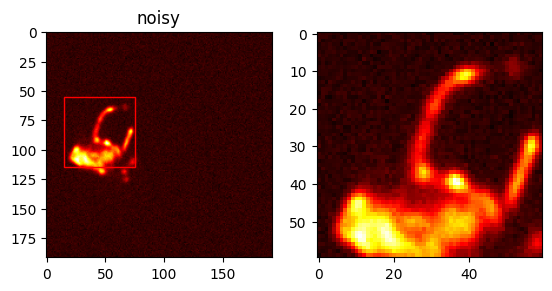

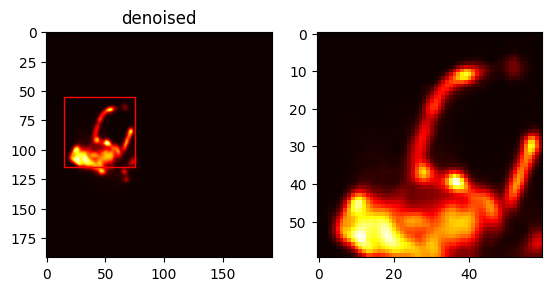

In [15]:
%matplotlib inline

#
time_idx = 11
depth_idx = 38

noisy_image = noisy_data[time_idx, depth_idx]
denoised_image = denoised_data[time_idx, depth_idx]


# calculate psnr, ssim between 
data_range_noisy = np.max(noisy_image).astype(np.int32) - np.min(noisy_image).astype(np.int32)
data_range_denoised = np.max(denoised_image).astype(np.int32) - np.min(denoised_image).astype(np.int32)
data_range = max(data_range_noisy, data_range_denoised)

print(f"PSNR: {cal_psnr(denoised_image, noisy_image, data_range=data_range)} SSIM: {cal_psnr(denoised_image, noisy_image, data_range=data_range)} MAE: {np.mean(np.abs(noisy_image - denoised_image))}")


# display image(s) in detail
zoom_coordinates = (55, 15, 60, 60)

plot_image_with_zoom(noisy_image, zoom_coordinates, title='noisy')
plot_image_with_zoom(denoised_image, zoom_coordinates, title='denoised')

## Calculate PSNR, SSIM, and MAE

In [18]:
# convert to float32 prevent overflow 
noisy_data = noisy_data.astype(np.float32)
denoised_data = denoised_data.astype(np.float32)

# 
data_range_noisy = np.max(noisy_data).astype(np.int32) - np.min(noisy_data).astype(np.int32)
data_range_denoised = np.max(denoised_data).astype(np.int32) - np.min(denoised_data).astype(np.int32)
data_range = max(data_range_noisy, data_range_denoised)

print("data_range: ", data_range)

psnr_values, ssim_values = [], []
# calcualte PSNR, SSIM between denoised data and noisy data
for denoised_vol, noisy_vol in zip(denoised_data, noisy_data):
    if np.array_equal(denoised_vol, noisy_vol):
        print(f"Images are identical" )
        continue
    else:
        data_range_noisy = np.max(noisy_vol).astype(np.int32) - np.min(noisy_vol).astype(np.int32)
        data_range_denoised = np.max(denoised_vol).astype(np.int32) - np.min(denoised_vol).astype(np.int32)
        data_range = max(data_range_noisy, data_range_denoised)
        #print(data_range)
        psnr_value = cal_psnr(denoised_vol, noisy_vol, data_range=data_range)
        ssim_value, _ = cal_ssim(denoised_vol, noisy_vol, full=True, data_range=data_range)
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)
    

data_range:  65535


In [19]:
mae_result = np.mean(np.abs(denoised_data - noisy_data))
psnr_result = np.nanmean(psnr_values)
ssim_result = np.nanmean(ssim_values)

print(f"MAE:{mae_result} PSNR:{psnr_result} SSIM:{ssim_result}")

MAE:451.65032958984375 PSNR:34.72361496430001 SSIM:0.7687773084893985
